# Lab 4 - Local evidence of climate change

## Testing the hypothesis: Attributes of weather have changed in the last 70 years in the vicinity of Heathrow airport.

You can get historic readings from UK weather stations <a href="https://www.metoffice.gov.uk/research/climate/maps-and-data/historic-station-data">UK Met Office</a> The most local is from Ringway (aka Manchester Airport), but this weather station closed in 2004. You will use data from Heathrow airport which runs through January 2023. Some data starts in 1948; others start later. This has been downloaded for you. 

The data is index by months and years. For each month, the data contains five attributes: minimum and maximum temperature (C&deg;) within each month, number of days with air frost per month, millimeters of rain in each month, and hours of sunshine  each month. 

I want you to find out if each of these attributes shows signs of change individually. For each attribute, find the statistical evidence of change or no change. In other words, you will test five hypotheses, one for each attribute. They will be of the form:
<br><br>
<center>The value of attribute X was higher/lower/different before year YYYY than after.</center>
<br>
It is up to you to decide what the dividing year should be, and whether it should be an upper-tail, lower-tail, or two-tail test. You can probably use the same dividing year for all five attributes. 

You may use any valid statistical method such as t/Z tests or bootstrapping. Whatever method you use, you will use it on five different datasets, so I encourage you to create reusable functions to save typing or cut-pasting. 

## 1. Preliminaries

#### Imports (add as needed)

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

#### Get the data

Read in the data to a pandas DataFrame

In [32]:
heathrow_df = pd.read_csv("Heathrow Weather Data.csv", na_values="---")

## 2. Clean the data - 2 marks

Examine the data. You will observe several issues

1. Do all the attributes start and end at the time? If not, record the start and end times so you can refer to the entire sequence of that attribute. Store in some data structure. 

2. Are all the attributes floats or are some strings? You need them to be floats. Convert if necessary. 

**Fix these issues and any others you find.**

### 2a. When year does the data start?

For each attribute, find the starting year and its index. Store in a data structure such as a dictionary. 

In [33]:
# Renamed to make naming easier
heathrow_df.rename(columns={'yyyy': 'year', 'tmax C': 'tmax', 'tmin C': 'tmin',
                   'air frost (days)': 'air_frost', 'rain (mm)': 'rain', 'sun (hours)': 'sun'}, inplace=True)

attributes = ["year", "tmax", "tmin", "air_frost", "rain", "sun"]

starting_year_dict = {}

for attr in attributes:
    # Get the first valid (non-NaN) index for the attribute.
    first_valid_index = heathrow_df[attr].first_valid_index()
    if first_valid_index is not None:
        # Get the corresponding year from the 'year' column.
        start_year = heathrow_df.loc[first_valid_index, "year"]
        starting_year_dict[attr] = {"start_year": start_year, "index": first_valid_index}
    else:
        starting_year_dict[attr] = {"start_year": None, "index": None}

print(starting_year_dict)

{'year': {'start_year': 1948, 'index': 0}, 'tmax': {'start_year': 1948, 'index': 0}, 'tmin': {'start_year': 1948, 'index': 0}, 'air_frost': {'start_year': 1949, 'index': 12}, 'rain': {'start_year': 1948, 'index': 0}, 'sun': {'start_year': 1957, 'index': 108}}


### 2b Convert any numbers represented as strings to floats. 

In order to produce plots, all numbers must be represented as floats or integers. 

In [34]:
heathrow_df['year'] = heathrow_df['year'].astype(int)
heathrow_df['month'] = heathrow_df['month'].astype(int)

for col in ['tmax', 'tmin', 'air_frost', 'rain', 'sun']:
    heathrow_df[col] = heathrow_df[col].astype(float)

### Report on cleaning the data.
Summarize what you did in the box below

First thing I did was declare "---" as NaN values so that pandas knew which items to clean
I then renamed the columns to make it easier to type and manage them later on
I listed out all of the attributes and then looped through them. For each attribute:
* I used first_valid_index() to find the first line on which the data is not NaN
* I then used loc() to locate what the year was on that line
* I then stored the year and index in the dictionary
* If the attribute doesn't exist (and therefore first_valid_index is None), then the attribute is added as "None" in the dictionary

## Wrangle the data - 2 marks

Observe the way time is represented, by year and month number with in that year. That is not convenient for producing plots and other visualizations. Create a column in the DataFrame which measures time in absolute months since January 1948. Display the first few rows and the last few rows of the DataFrame to show that you have does this. 

In [35]:
# This gets the difference from 1984, then adds the month
# For example, March 1983 would be (1983-1948) * 12 [how many full months] + (3) [How many extra months minus 1 to account for the offset from January]
heathrow_df["absolute_month"] = (heathrow_df["year"] - 1948) * 12 + (heathrow_df["month"]- 1)

# Display the first few rows
print("First few rows:")
print(heathrow_df.head())

# Display the last few rows
print("\nLast few rows:")
print(heathrow_df.tail())

First few rows:
   year  month  tmax  tmin  air_frost  rain  sun  absolute_month
0  1948      1   8.9   3.3        NaN  85.0  NaN               0
1  1948      2   7.9   2.2        NaN  26.0  NaN               1
2  1948      3  14.2   3.8        NaN  14.0  NaN               2
3  1948      4  15.4   5.1        NaN  35.0  NaN               3
4  1948      5  18.1   6.9        NaN  57.0  NaN               4

Last few rows:
     year  month  tmax  tmin  air_frost   rain    sun  absolute_month
896  2022      9  20.2  11.8        0.0   86.0  119.1             896
897  2022     10  18.3  10.4        0.0   81.4  132.8             897
898  2022     11  13.2   7.6        0.0  123.8   69.9             898
899  2022     12   7.9   1.7       11.0   50.2   56.4             899
900  2023      1   9.0   2.5       10.0   66.2   68.2             900


## 3. Explore and visualize the data

- Plot each attribute to see if there is visual evidence of change over time. 

- Determine whether there is visual evidence that the data is from a normal distribution. (Does the data look normally distributed?)

- Do any other visualization which you deem useful.

- **Label the axis of your graphs.** 

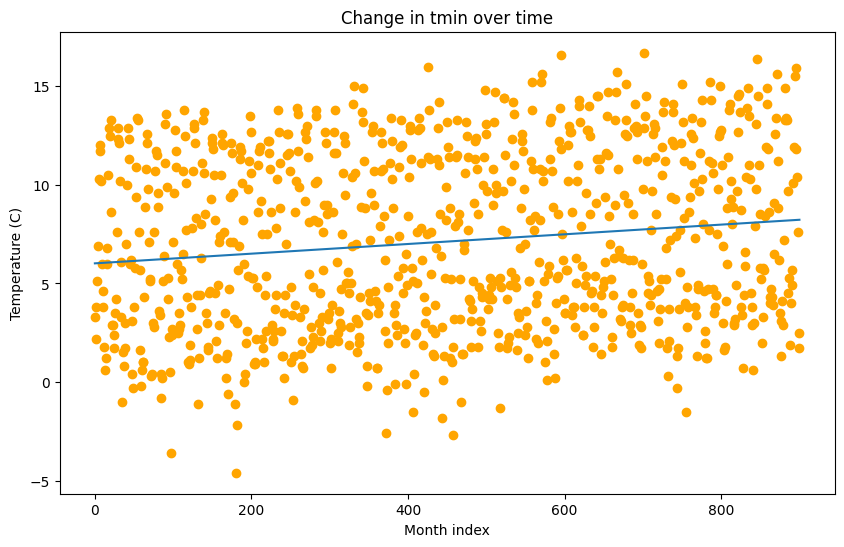

LinregressResult(slope=0.0024556799417252573, intercept=6.017918499031625, rvalue=0.14303121429844656, pvalue=1.6359774953374208e-05, stderr=0.0005667253485367039, intercept_stderr=0.2945609176810362)
mean = 7.122974472807991
median = 6.7
mode = 6.7


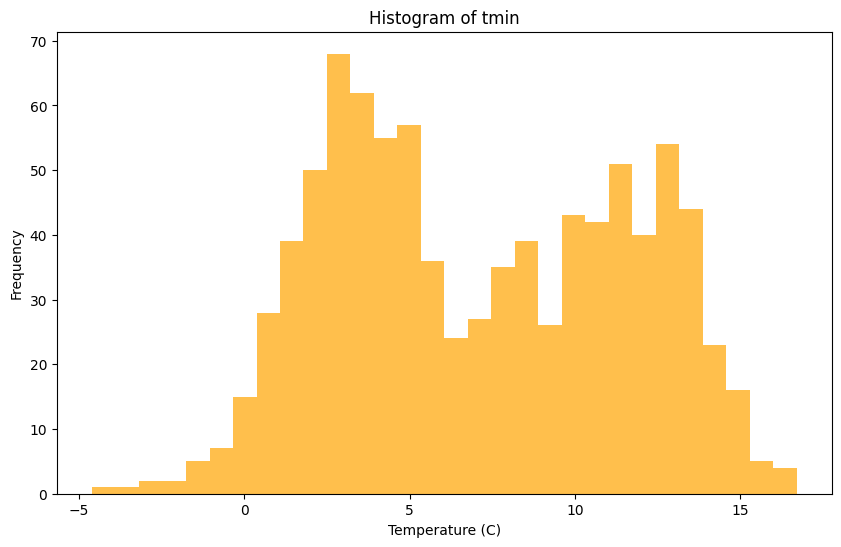

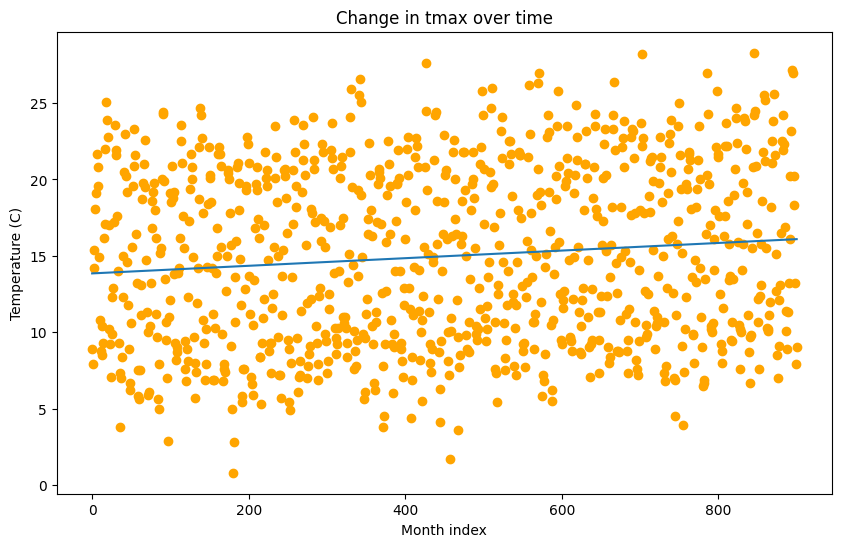

LinregressResult(slope=0.0024918965787377578, intercept=13.850566628358244, rvalue=0.11173912410846468, pvalue=0.0007796888210084302, stderr=0.0007391228298228876, intercept_stderr=0.3841661566643931)
mean = 14.971920088790235
median = 14.8
mode = 14.8


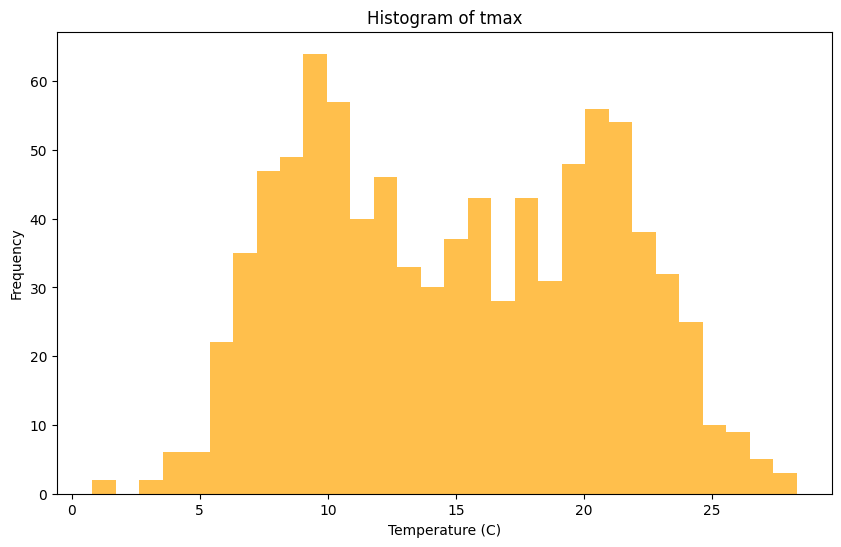

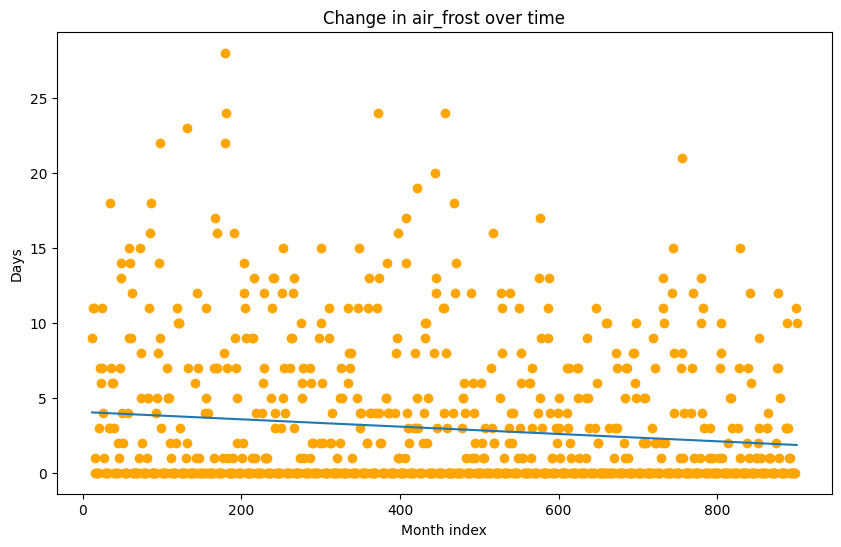

LinregressResult(slope=-0.0024427689782020494, intercept=4.04866080929073, rvalue=-0.1353454192548881, pvalue=5.1560783556299916e-05, stderr=0.0006004299591769477, intercept_stderr=0.3141780958925086)
mean = 2.9347581552305964
median = 0.0
mode = 0.0


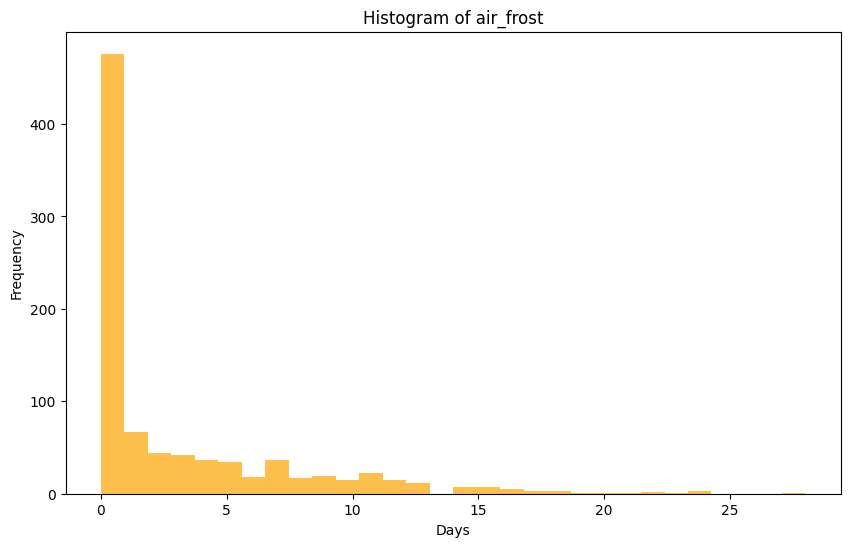

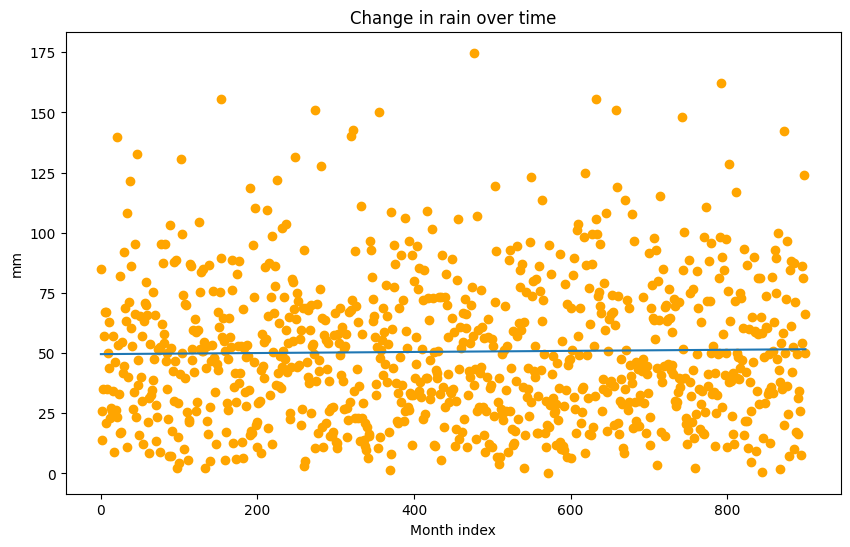

LinregressResult(slope=0.0022534163814042544, intercept=49.57619570272991, rvalue=0.019652969469408272, pvalue=0.5557576357688567, stderr=0.0038233982303417344, intercept_stderr=1.9872477811296831)
mean = 50.59023307436183
median = 47.0
mode = 47.0


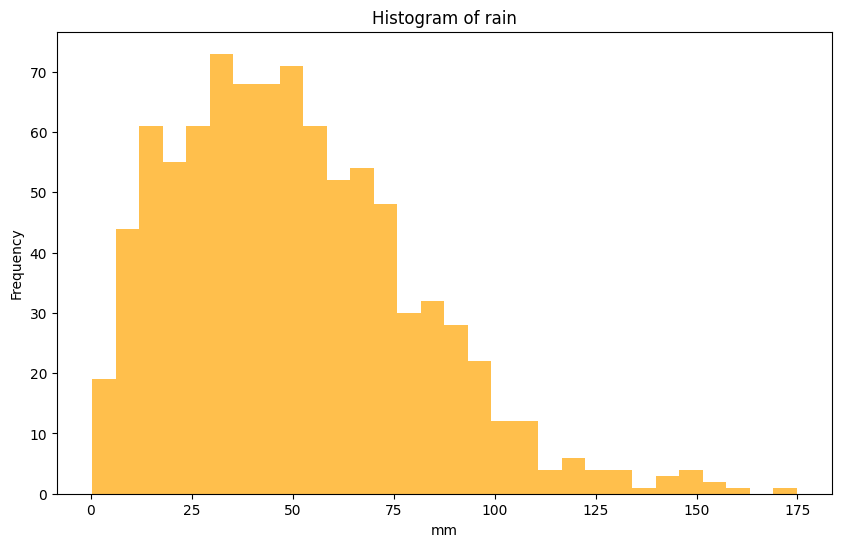

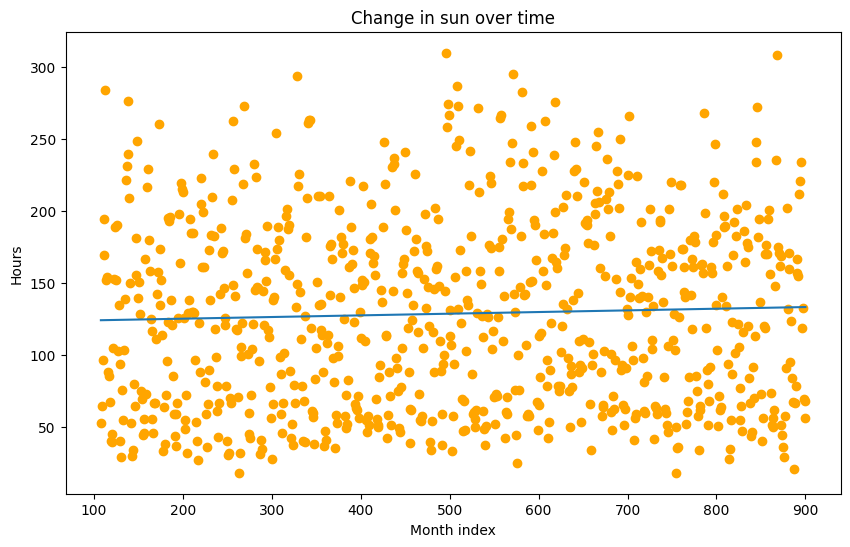

LinregressResult(slope=0.011537486958678681, intercept=123.13870051986252, rvalue=0.040751786977886874, pvalue=0.2516930978930142, stderr=0.010058087420172989, intercept_stderr=5.567676072863387)
mean = 128.95359394703658
median = 125.6
mode = 125.6


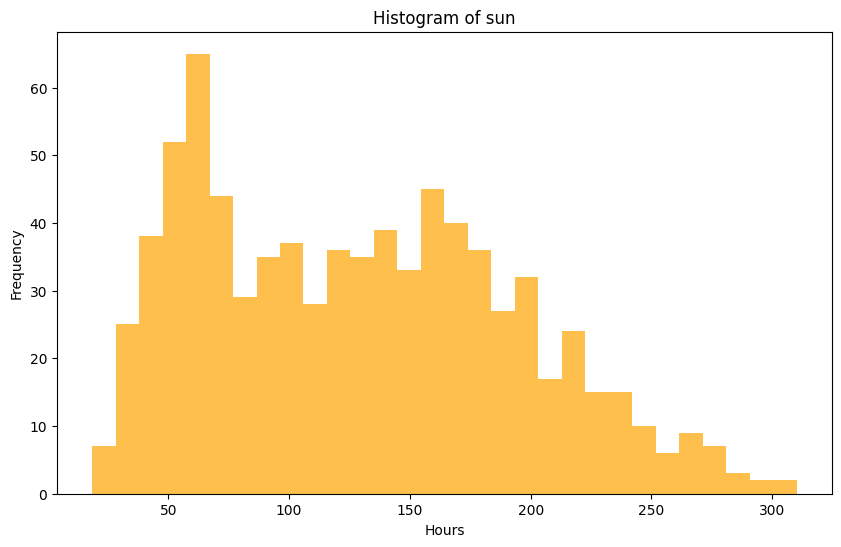

In [36]:
def plotData(name, label):
    plt.figure(figsize=(10, 6))

    heathrow_clone = heathrow_df.copy(deep=True)

    heathrow_clone = heathrow_clone.dropna(subset=[f"{name}"])
    xpoint = heathrow_clone["absolute_month"]
    ypoint = heathrow_clone[f"{name}"]

    plt.title(f"Change in {name} over time")
    plt.scatter(xpoint, ypoint, c="orange")
    plt.plot(np.unique(xpoint), np.poly1d(np.polyfit(xpoint, ypoint, 1))(np.unique(xpoint)))
    plt.xlabel("Month index")
    plt.ylabel(f"{label}")
    plt.show()

    print(stats.linregress(xpoint, ypoint))
    print(f"mean = {ypoint.mean()}")
    print(f"median = {ypoint.median()}")
    print(f"mode = {ypoint.median()}")

    # Histogram to check for normal distribution
    plt.figure(figsize=(10, 6))
    plt.hist(heathrow_clone[f"{name}"], bins=30, alpha=0.7, color='orange')
    plt.title(f"Histogram of {name}")
    plt.xlabel(f"{label}")
    plt.ylabel("Frequency")
    plt.show()

plotData("tmin", "Temperature (C)")
plotData("tmax", "Temperature (C)")
plotData("air_frost", "Days")
plotData("rain", "mm")
plotData("sun", "Hours")

### 3a. Summarize your findings in the box below for each attribute - 1 mark for each attribute.

* The r value of both tmin and tmax is positive, however it is only about 0.1, meaning that it's a weak positive correlation
* Since the p value of both max and min are <= 0.05, the test is also statistically significant, meaning that the positive correlation stands (rejecting the null hypothesis of the temperature not changing)
* The data does not appear to be normally distributed, as it has two peaks
* However, by looking at the mean, meadian and mode of the tmax temperatures, they are all very similar, which would lead a person to believe that they are normally distributed
* However, due to the two peaks and the histograms not following the general shape of a normal distribution curve, we can say with confidence that the points are not normally distributed

* For the rest of the values, like rain, air_frost and sun, there is no normal distribution going on as the histograms are all skewed.

## 4. Removal of seasonality and data smoothing

Any long-term change is hard to see by eye, because of the 12-month periodicity (winter, spring, summer, fall). Remove this to smooth the data. What is the best way to remove the seasonality and smooth the data.  

1. &#x2610; Average over months? How many months?

2. &#x2610; Use only a single month per year? Which one?

3. &#x2610; Some other method. Describe in the next box.


Discuss in the next box what method you used to smooth the data, and why you chose this.

## 2 marks

There are two main methods of smoothing that I would use: 12-month moving average and seasonal decomposition.

12-month moving average smooths a time series by caclulating the average of the values for each consecutive 12-month period. To work this average out, you take the current month and add the previous 11 months to it. I then would take that value and plot it. This neutralises seasonal effects because the window spans the full year for all months (meaning that they all account for the seasonal changes)

Seasonal decomposition can be applied using Seasonal and Trend decomposition using losses. This decomposition makes it easier to analyse each part independently and understand what's driving the behaviour in the data. This also allows us identiy outliers or anomalies that might indicate unusual events (such as a really hot day in winter). We can also more clearly see periodic, seasonal patterns.

## Plot the smoothed data to see if 

1. You see signs of change visually.

2. What absolute month the change took place (to help you decide where to divide the data).

Comment on this in the box below for each attribute.

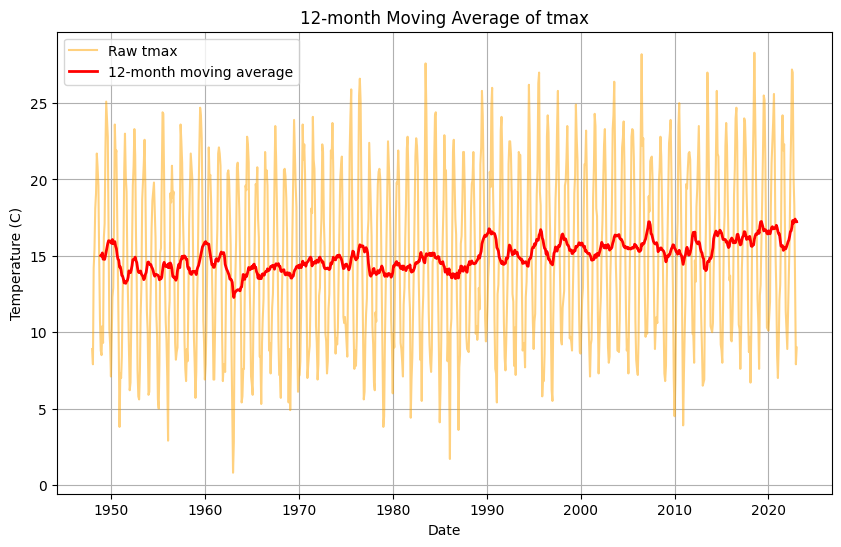

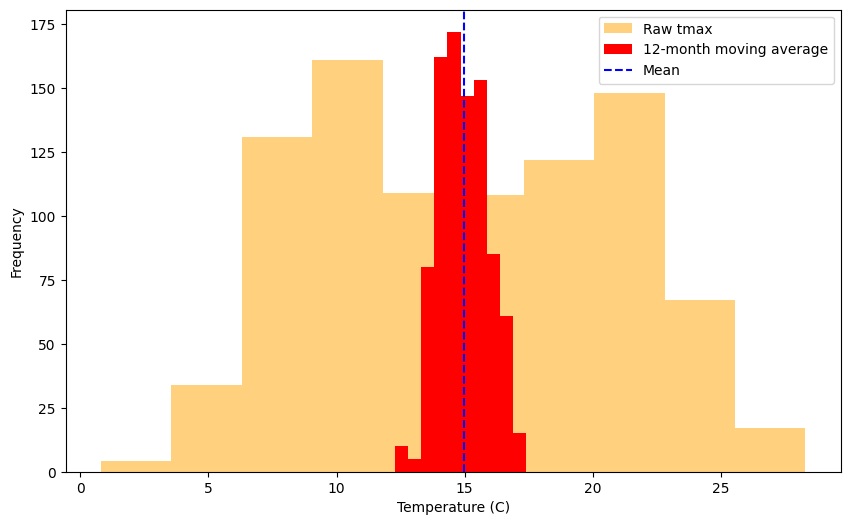

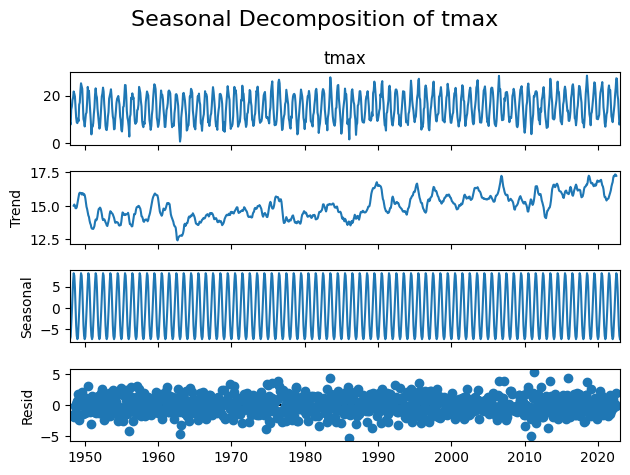

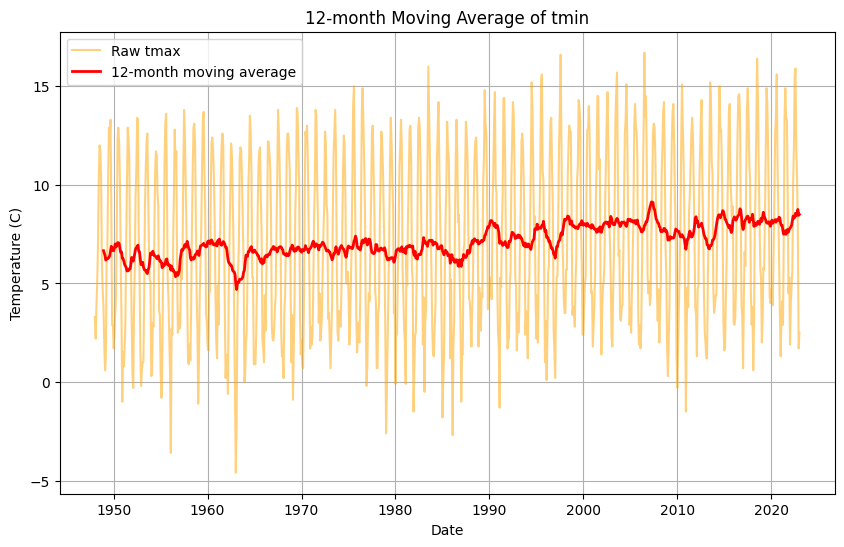

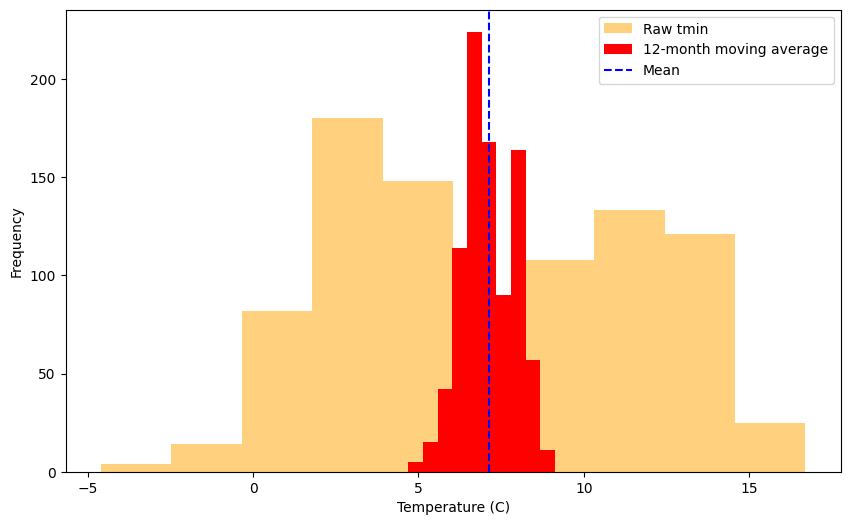

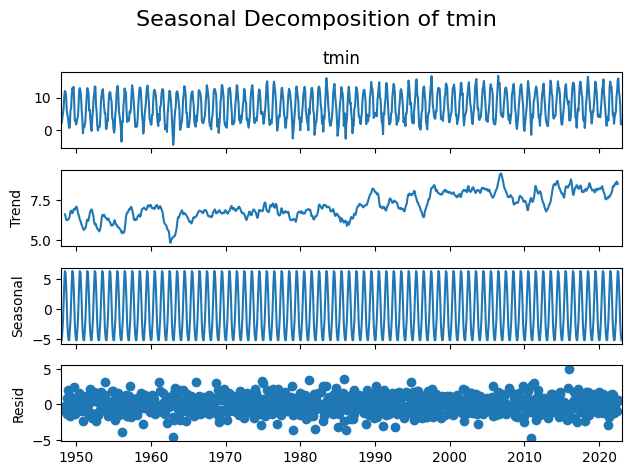

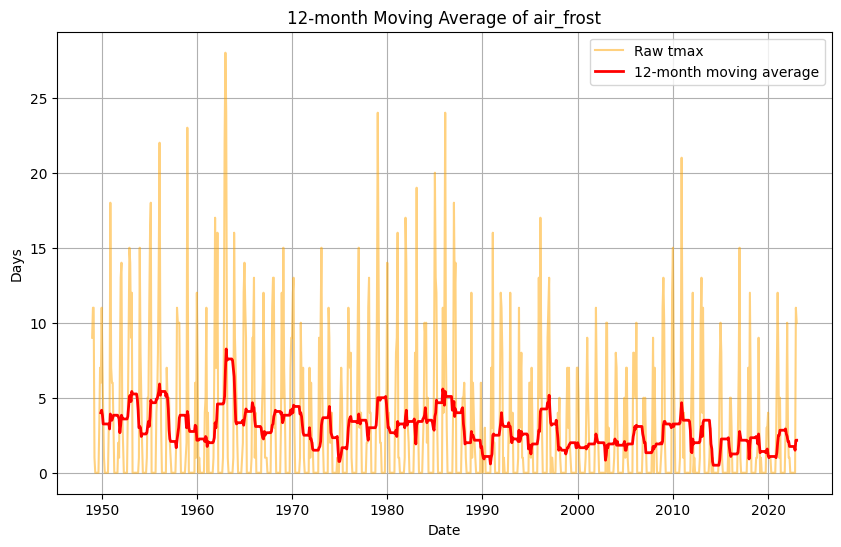

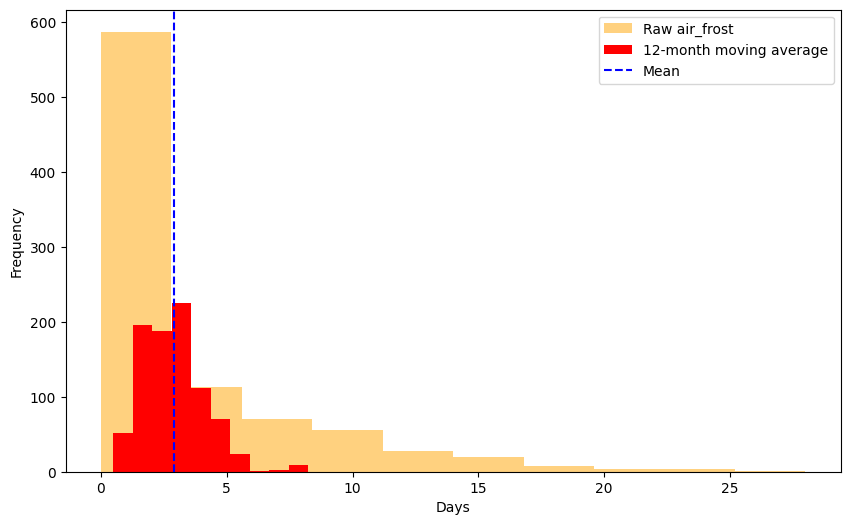

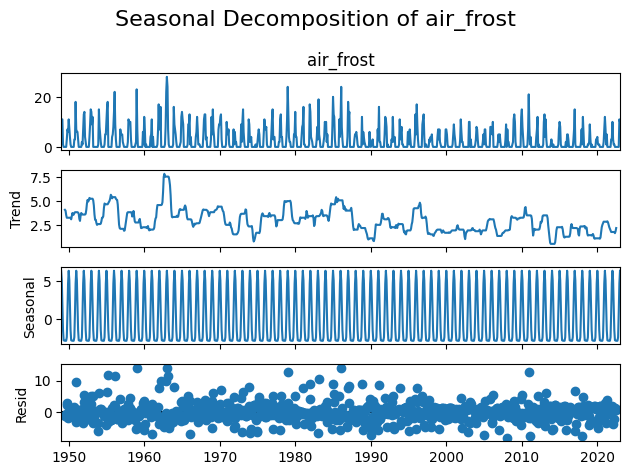

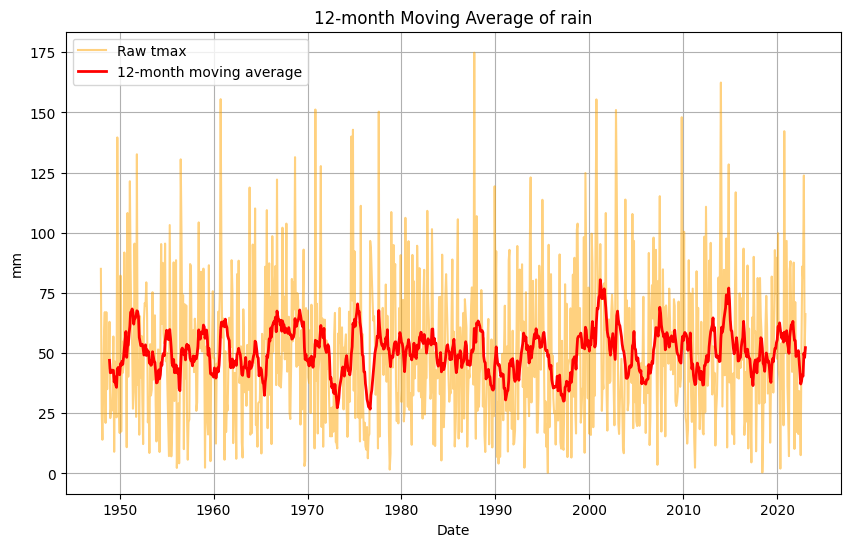

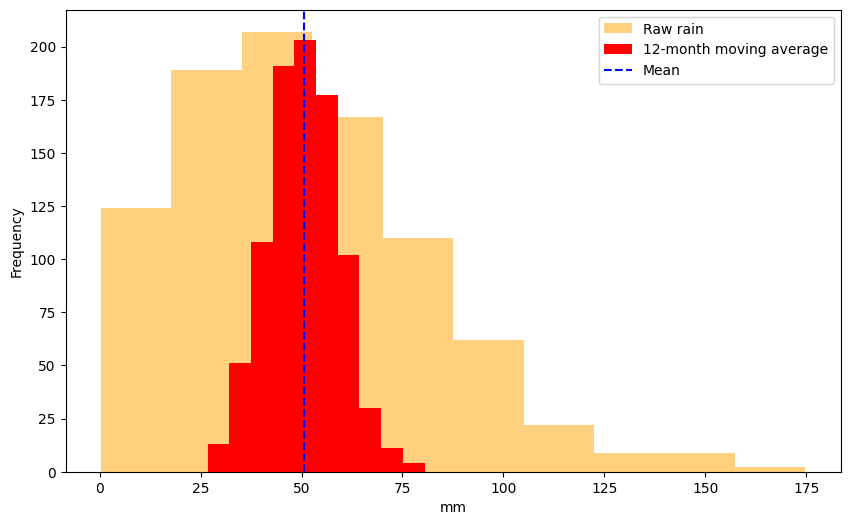

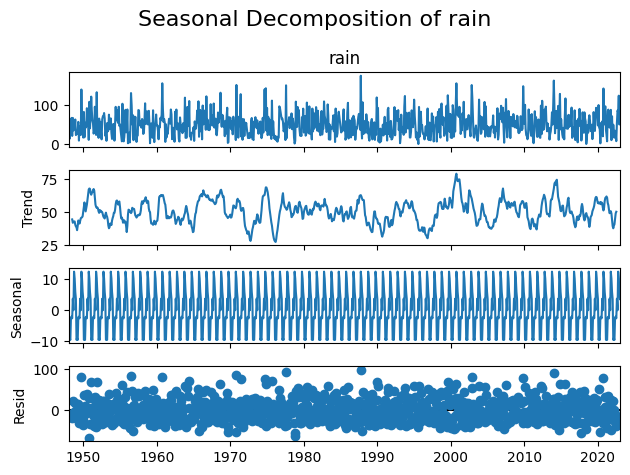

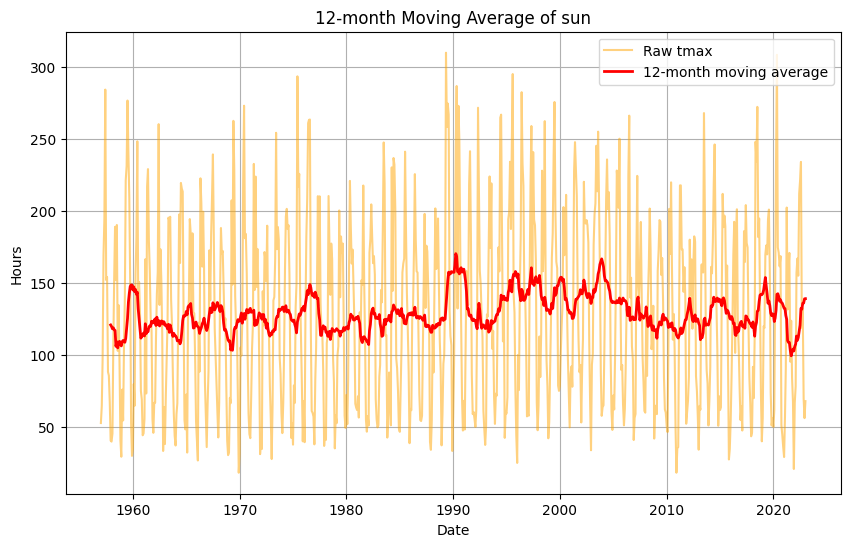

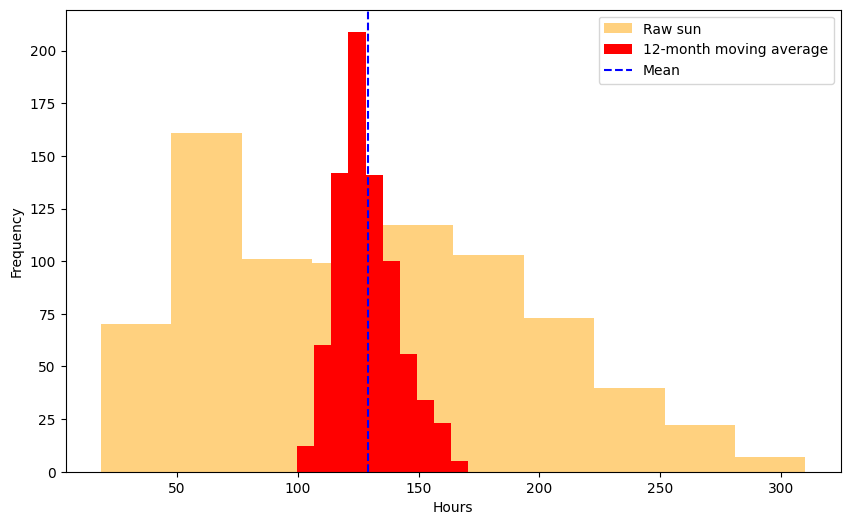

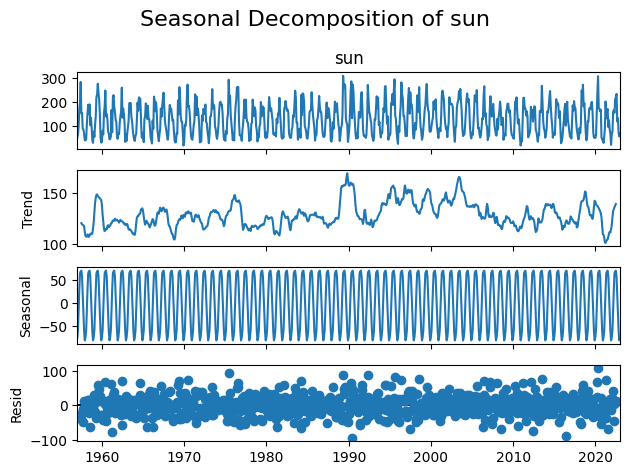

In [37]:
heathrow_df["date"] = pd.to_datetime(heathrow_df[["year", "month"]].assign(day=1))
heathrow_df.set_index("date", inplace=True)
heathrow_df.sort_index(inplace=True)

def plotSmooth(name, label):
    # 12 point moving average for tmax and tmin
    # Uses center=False to make sure the average is right-aligned, which makes past trends more visible

    heathrow_clone2 = heathrow_df.copy(deep=True)
    heathrow_clone2 = heathrow_clone2.dropna(subset=[f"{name}"])
    heathrow_clone2[f"{name}_moving_average"] = heathrow_clone2[f"{name}"].rolling(window=12, center=False).mean()

    # Plotting 12-month moving average:
    plt.figure(figsize=(10, 6))
    plt.plot(heathrow_clone2.index, heathrow_clone2[f'{name}'], label='Raw tmax', alpha=0.5, color='orange')
    plt.plot(heathrow_clone2.index, heathrow_clone2[f'{name}_moving_average'], label='12-month moving average', color='red', linewidth=2)
    plt.title(f"12-month Moving Average of {name}")
    plt.xlabel("Date")
    plt.ylabel(f"{label}")
    plt.legend()
    plt.grid()
    plt.show()

    mean = heathrow_clone2[f"{name}_moving_average"].mean()
    plt.figure(figsize=(10, 6))
    plt.hist(heathrow_clone2[f'{name}'], label=f'Raw {name}', color='orange', alpha=0.5)
    plt.hist(heathrow_clone2[f'{name}_moving_average'], label='12-month moving average', color='red')
    plt.axvline(x=mean, color="blue", linestyle="--", label="Mean")
    plt.xlabel(f"{label}")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    decomposition_result = seasonal_decompose(heathrow_clone2[f'{name}'], model='additive', period=12)
    decomposition_result.plot()
    plt.suptitle(f"Seasonal Decomposition of {name}", fontsize=16)
    plt.tight_layout()
    plt.show()

plotSmooth("tmax", "Temperature (C)")
plotSmooth("tmin", "Temperature (C)")
plotSmooth("air_frost", "Days")
plotSmooth("rain", "mm")
plotSmooth("sun", "Hours")


From the data, I can see that after smoothing the data, there is a clear trend pointing that the temperatures have risen. By looking at the Residual of the decomposed seasonal smoothening, I can tell that there have been multiple times where the data has gone both above and below the expected trend. For example, in between 2010 and 2020, there was quite a few points which were way above average. We can see that hours of sun has also risen over time though less drastically than temperature, and air frost has slightly decreased.

After applying a moving average of 12 months, it is clearer to see that all of the data points actually do have a normal distribution (as the histograms more clearly resemble a bell curve, and the mean is close to the peak), this suggests that the observed trend isn't being skewed by a few outlier events, and that our models assumptions for further statistical analysis are more likely to hold (which is important for the next exercise).

## 5. Perform the statistical test 

Divide the data into two parts; an early phase and a recent phase. You decide which year or absolute month should be chosen as the change point, or divide it in half.  Investigate statistically whether the two periods are statistically different or not for each attribute. **Use $\alpha$ value of $0.01$**. 


### 5a. Write code to perform the statistical test for any attribute.  4 marks
The comparison of two means depends on the two data sets, the $\alpha$-value and the type of test. Your task for this part is to write some code which will take as input the two dataset being compared, the alpha values, and the type of test. The output will be the result of the test. My solution is described below. Yours can be different, but should give similar results. 

**Jonathan's solution:**
Input: The dataframe,the starting index for the early data, the starting index for the recent data and the critical value. For a lower-tail test, the critical value will be negative; for a upper-tail test, the critical value will be positive, and for a two-tailed test, the critical value a list of two values, `[-c,c]`, where `c` are the values associated with $\alpha/2$ and $1-\alpha/2$. The output will give the value of the test statistics (which the code computes) the critical value, and the conclusion ('Reject the Null'/'Fail to reject the Null'). It also plotted the means with SEM errorbars. 

#### For help with computing critical values, see Appendix A.

<img src="https://www.dropbox.com/scl/fi/g6y5iomb6cwwqv6lak743/Example_output.png?rlkey=r933o6fzf27ydbb535aria34o&st=4hjzfqvj&raw=1">

# Results - 5 marks

For each attribute, give the type of test, the test statistic, the critical value, and the conclusion. 

Testing for attribute: tmax (Before 1985 vs. After 1985)
This is an upper, one-tail statistical hypothesis test for tmax
Difference in means (after - before): 1.151549470696077
Standard error: 0.38500073454141953
Test statistic of 2.9910318796344786 is higher than critical value of 2.33
Therefore, reject null hypothesis (attribute increased after cutoff)


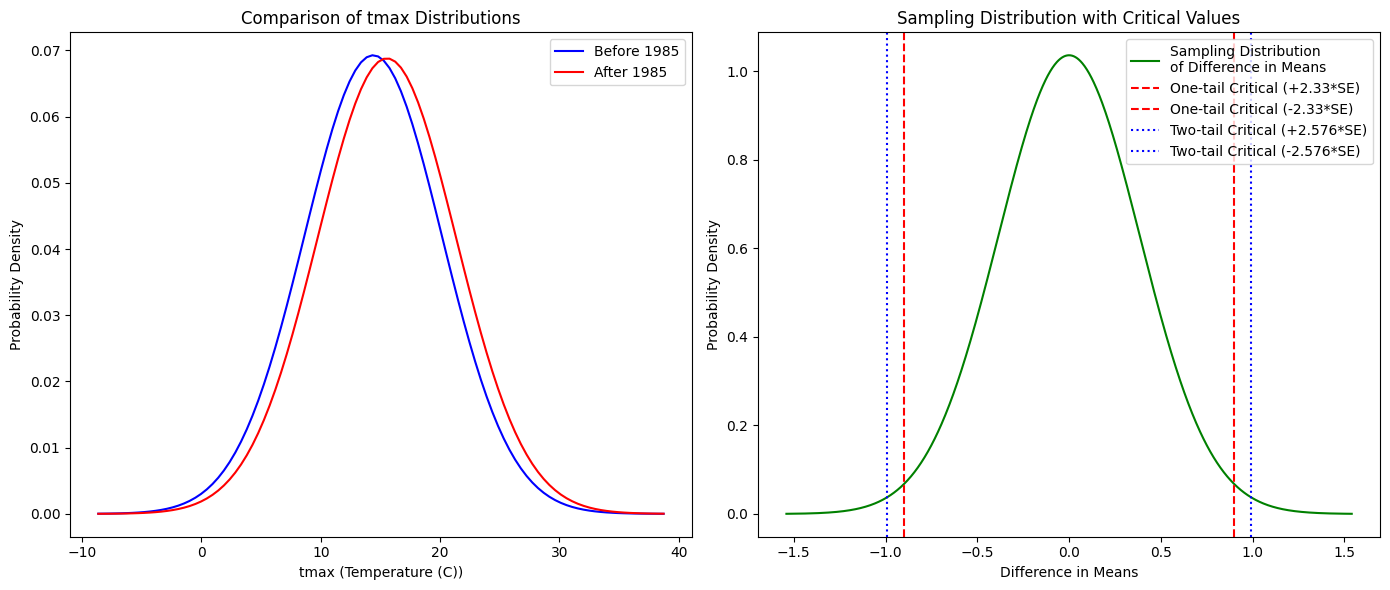

Testing for attribute: tmin (Before 1985 vs. After 1985)
This is an upper, one-tail statistical hypothesis test for tmin
Difference in means (after - before): 1.1078917538983184
Standard error: 0.29560800820539573
Test statistic of 3.7478407997950036 is higher than critical value of 2.33
Therefore, reject null hypothesis (attribute increased after cutoff)


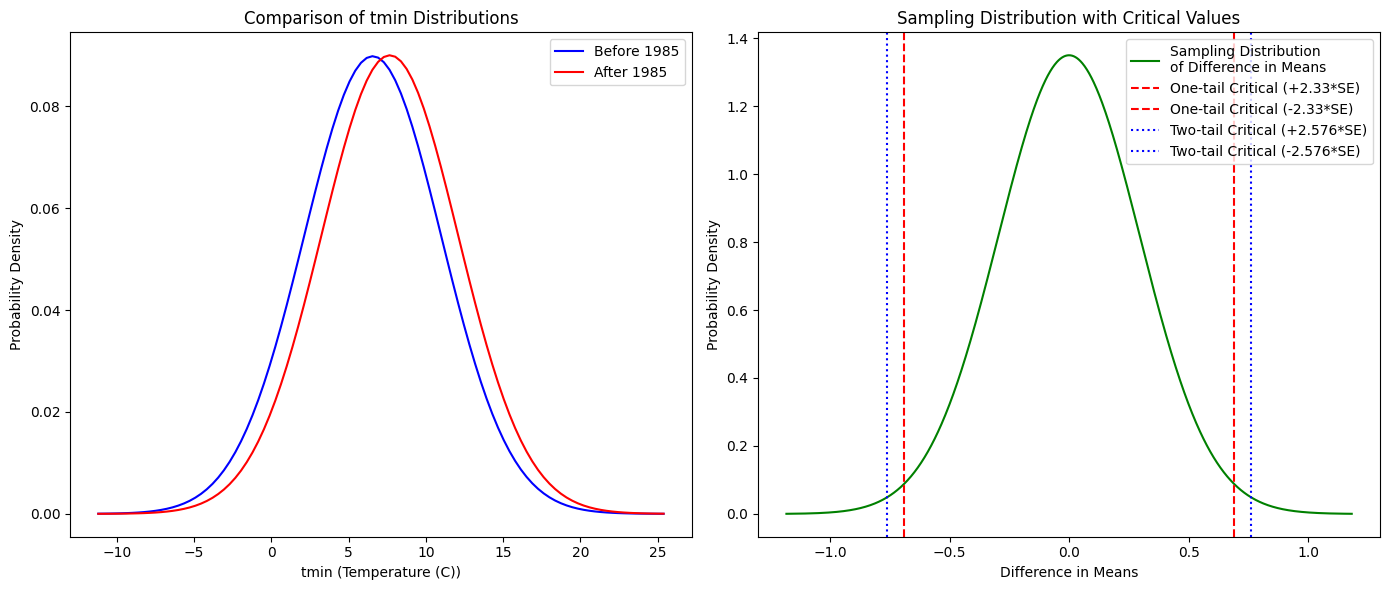

Testing for attribute: rain (Before 1985 vs. After 1985)
This is a two-tailed statistical hypothesis test for rain
Difference in means (after - before): -0.048118851893470094
Standard error: 1.988423356066927
Test statistic of -0.02419950044675018 is within the critical values of +-2.576
Therefore, accept null hypothesis (no change)


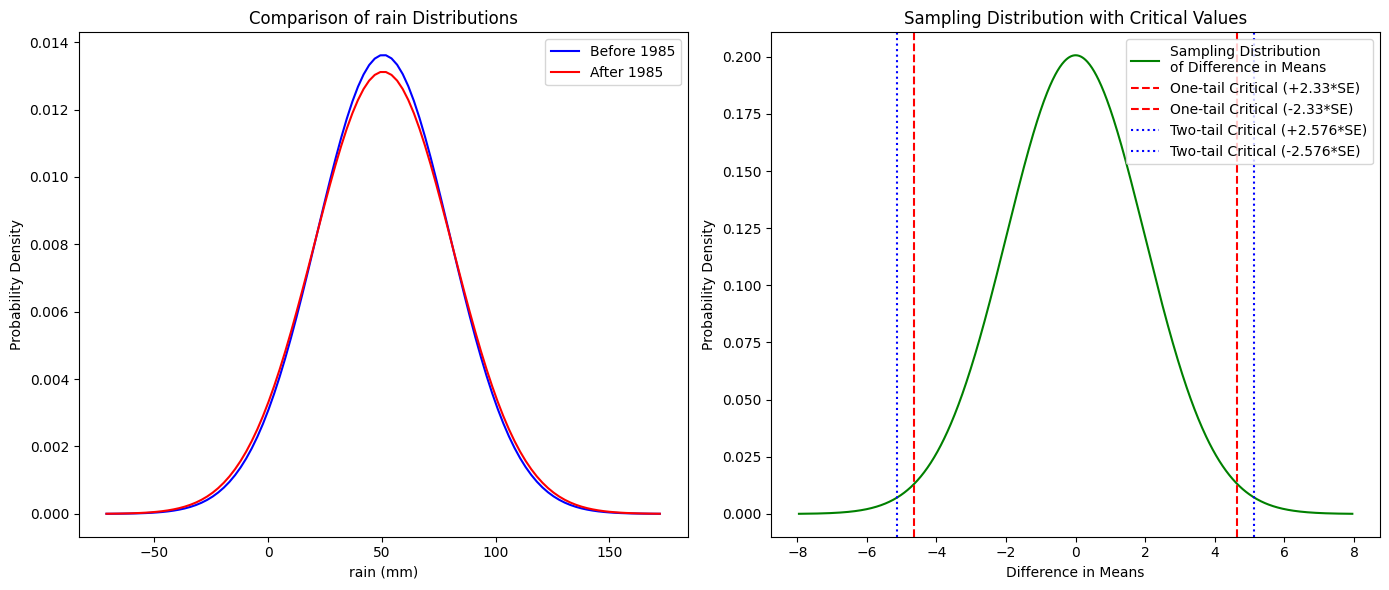

Testing for attribute: air_frost (Before 1985 vs. After 1985)
This is a two-tailed statistical hypothesis test for air_frost
Difference in means (after - before): -1.063538374260475
Standard error: 0.3085162989665498
Test statistic of -3.447268030321428 is outside the critical values of +-2.576
Therefore, reject null hypothesis (there was a change)


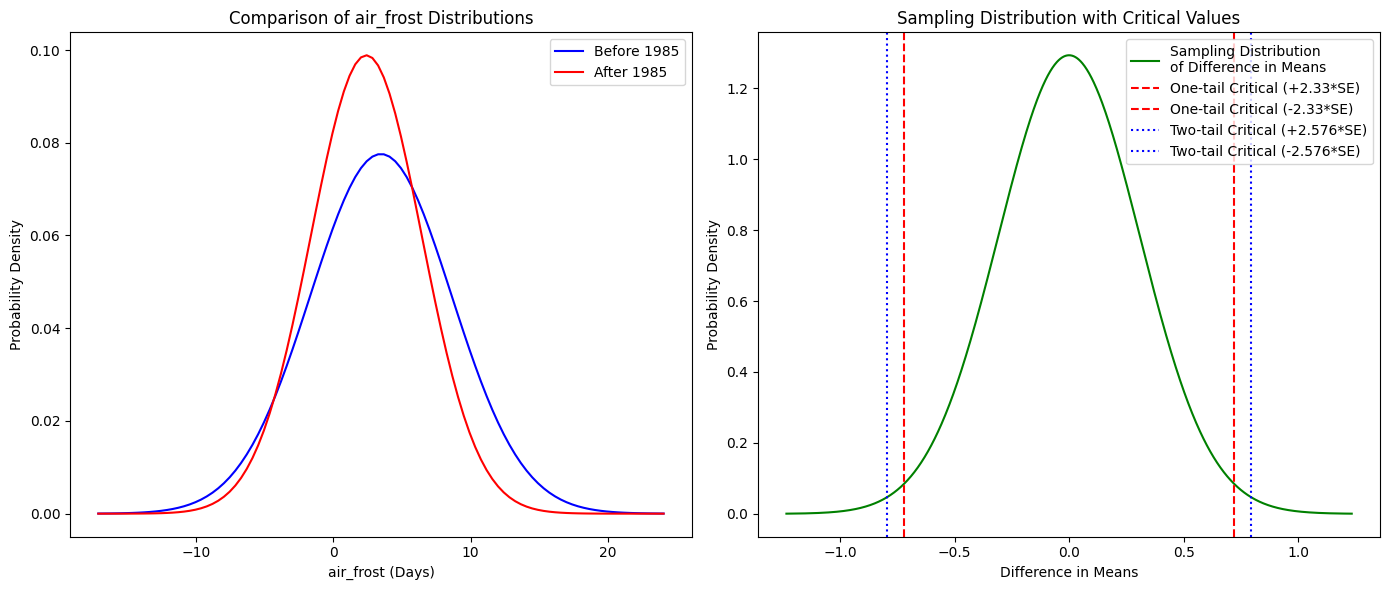

Testing for attribute: sun (Before 1985 vs. After 1985)
This is a two-tailed statistical hypothesis test for sun
Difference in means (after - before): 8.91065046368658
Standard error: 4.306572353278394
Test statistic of 2.069081797012725 is within the critical values of +-2.576
Therefore, accept null hypothesis (no change)


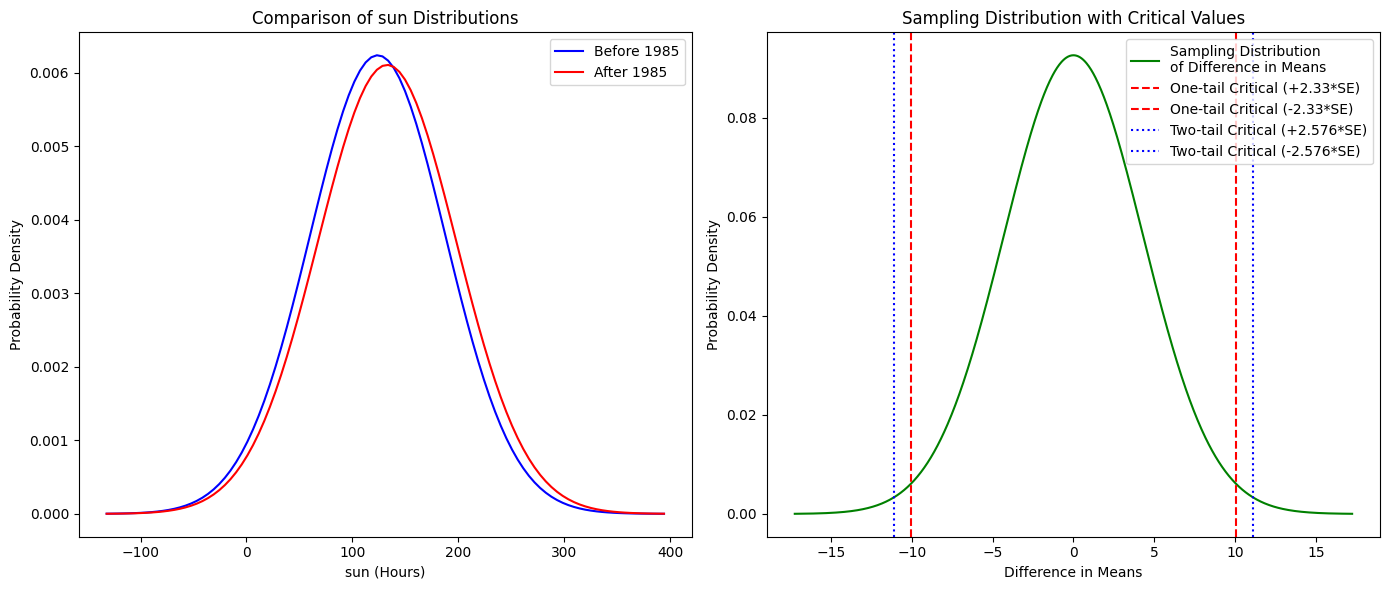

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

CUTOFF_YEAR = 1985

first_half_df = heathrow_df[heathrow_df["year"] < CUTOFF_YEAR].copy(deep=True)
second_half_df = heathrow_df[heathrow_df["year"] >= CUTOFF_YEAR].copy(deep=True)

# Define sample sizes
n1 = len(first_half_df)
n2 = len(second_half_df)

# Critical z-values for one-tail and two-tail tests
z_crit_one_tail = 2.33
z_crit_two_tail = 2.576

def statTest(name, label, test_type):
    first_mean = first_half_df[f"{name}"].mean()
    first_std = first_half_df[f"{name}"].std()
    second_mean = second_half_df[f"{name}"].mean()
    second_std = second_half_df[f"{name}"].std()
    
    # Create x-range to cover ±4 standard deviations for a nice plot
    x_min = min(first_mean - 4*first_std, second_mean - 4*second_std)
    x_max = max(first_mean + 4*first_std, second_mean + 4*second_std)
    x = np.linspace(x_min, x_max, 100)
    
    normalFirst = norm.pdf(x, first_mean, first_std)
    normalSecond = norm.pdf(x, second_mean, second_std)
    
    se = math.sqrt((first_std**2)/n1 + (second_std**2)/n2)

    z_statistic = (second_mean - first_mean) / se

    # Print test details and results
    print(f"Testing for attribute: {name} (Before {CUTOFF_YEAR} vs. After {CUTOFF_YEAR})")
    if test_type == "upper":
        print(f"This is an upper, one-tail statistical hypothesis test for {name}")
        print(f"Difference in means (after - before): {second_mean - first_mean}")
        print(f"Standard error: {se}")
        if z_statistic > z_crit_one_tail:
            print(f"Test statistic of {z_statistic} is higher than critical value of {z_crit_one_tail}")
            print("Therefore, reject null hypothesis (attribute increased after cutoff)")
        else:
            print(f"Test statistic of {z_statistic} is lower than critical value of {z_crit_one_tail}")
            print("Therefore, accept null hypothesis (no increase observed)")
    
    elif test_type == "lower":
        print(f"This is a lower, one-tail statistical hypothesis test for {name}")
        print(f"Difference in means (after - before): {second_mean - first_mean}")
        print(f"Standard error: {se}")
        if z_statistic < -z_crit_one_tail:
            print(f"Test statistic of {z_statistic} is lower than critical value of {-z_crit_one_tail}")
            print("Therefore, reject null hypothesis (attribute decreased after cutoff)")
        else:
            print(f"Test statistic of {z_statistic} is higher than critical value of {-z_crit_one_tail}")
            print("Therefore, accept null hypothesis (no decrease observed)")
    
    elif test_type == "two":
        print(f"This is a two-tailed statistical hypothesis test for {name}")
        print(f"Difference in means (after - before): {second_mean - first_mean}")
        print(f"Standard error: {se}")
        if z_statistic > z_crit_two_tail or z_statistic < -z_crit_two_tail:
            print(f"Test statistic of {z_statistic} is outside the critical values of +-{z_crit_two_tail}")
            print("Therefore, reject null hypothesis (there was a change)")
        else:
            print(f"Test statistic of {z_statistic} is within the critical values of +-{z_crit_two_tail}")
            print("Therefore, accept null hypothesis (no change)")
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, normalFirst, label="Before " + str(CUTOFF_YEAR), color="blue")
    plt.plot(x, normalSecond, label="After " + str(CUTOFF_YEAR), color="red")
    plt.title(f"Comparison of {name} Distributions")
    plt.xlabel(f"{name} ({label})")
    plt.ylabel("Probability Density")
    plt.legend()
    
    x_diff = np.linspace(-4*se, 4*se, 1000)
    pdf_diff = norm.pdf(x_diff, loc=0, scale=se)
    plt.subplot(1, 2, 2)
    plt.plot(x_diff, pdf_diff, label="Sampling Distribution\nof Difference in Means", color="green")
    
    plt.axvline(z_crit_one_tail * se, color="red", linestyle="--", label=f"One-tail Critical (+{z_crit_one_tail}*SE)")
    plt.axvline(-z_crit_one_tail * se, color="red", linestyle="--", label=f"One-tail Critical (-{z_crit_one_tail}*SE)")
    # Two-tail critical values
    plt.axvline(z_crit_two_tail * se, color="blue", linestyle=":", label=f"Two-tail Critical (+{z_crit_two_tail}*SE)")
    plt.axvline(-z_crit_two_tail * se, color="blue", linestyle=":", label=f"Two-tail Critical (-{z_crit_two_tail}*SE)")
    
    plt.title("Sampling Distribution with Critical Values")
    plt.xlabel("Difference in Means")
    plt.ylabel("Probability Density")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

statTest("tmax", "Temperature (C)", "upper")
statTest("tmin", "Temperature (C)", "upper")
statTest("rain", "mm", "two")
statTest("air_frost", "Days", "two")
statTest("sun", "Hours", "two")


# Appendices

## Appendix A: Getting critical values

For a z-test, you will need properties from the normal distribution. For a t-test, you will need properties of the Student-t distribution. There are many to get these in python. One way is to use `scipy.stats`. You can `from scipy import stats` which gives you all of stats, or just import the normal distribution, which is called norm - `from scipy.stats import norm`, or import the t-distribution, `from scipy.stats import t`. 

In [39]:
from scipy.stats import norm
from scipy.stats import t
import scipy.stats

For all distributions in scipy.stats, the method .pdf gives the probability distribution, .cdf gives the cumulative distribution, .ppf gives an inverse of the cdf (very useful), and .interval gives a confidence interval. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm.

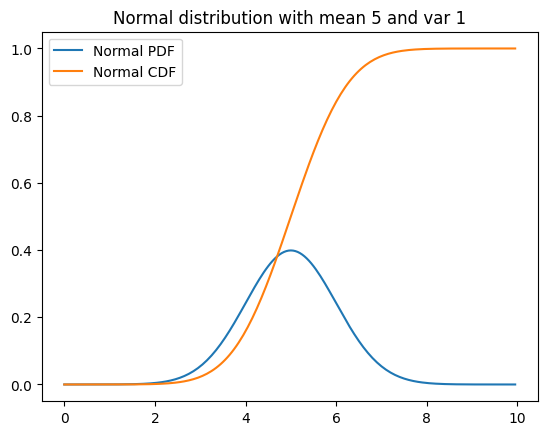

In [40]:
import numpy as np
import matplotlib.pyplot as plt
x=np.arange(0,10,0.05)
y=norm.pdf(x,5,1) # PDF of a normal distribution with mean 5 and variance 1
z=norm.cdf(x,5,1) # CDF of a normal distribution with mean 5 and variance 1
plt.plot(x,y,label='Normal PDF')
plt.plot(x,z,label='Normal CDF')
plt.legend()
plt.title('Normal distribution with mean 5 and var 1')
plt.show()

## Two-tailed test

The confidence interval is a function of $\alpha$
 and is the smallest interval which contains $1-\alpha$
of the probability. For a two-tailed test, if the test statistic is outside
the confidence interval, the null hypothesis is rejected; if it is inside the confidence interval, the null hypothesis is not rejected. All distributions in `scipy.stats` have a method `interval` which computes confidence interval.

The 95% confidence interval lies between 3.04 and 6.96.


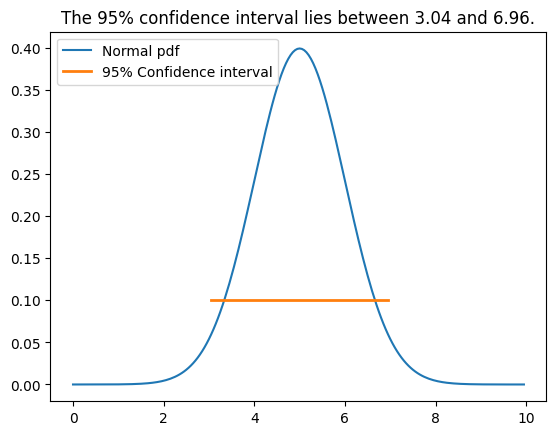

In [41]:
alpha = 0.05
x=np.arange(0,10,0.05)
y=scipy.stats.norm.pdf(x,5,1) # a normal distribution with mean 5 and variance 1
plt.plot(x,y,label='Normal pdf')
ci=scipy.stats.norm.interval(1-alpha,5,1)
print("The 95%% confidence interval lies between %3.2f and %3.2f." %(ci[0],ci[1]))
plt.plot([ci[0],ci[1]],[0.1,0.1],linewidth=2.0,label="95% Confidence interval")
plt.legend(loc=2)
plt.title("The 95%% confidence interval lies between %3.2f and %3.2f." %(ci[0],ci[1]))
plt.show()

### One tail test
Here is where `ppf` (the inverse of the cumulative distribution) is very useful. The lower tail critical value is where the cumulative distribution is equal to $\alpha$. The upper tail critical value is where the cumulative distribution is equal to $1-\alpha$. For a symmetric distribution (such as the normal or t distributions) the two critical values will be the same magnitude, but the lower tail critical value will be negative and the upper-tail critical value will be positive. In general they will have different magnitudes.

#### Lower tail and upper tail of a normal distribution with mean 5 and variance 1

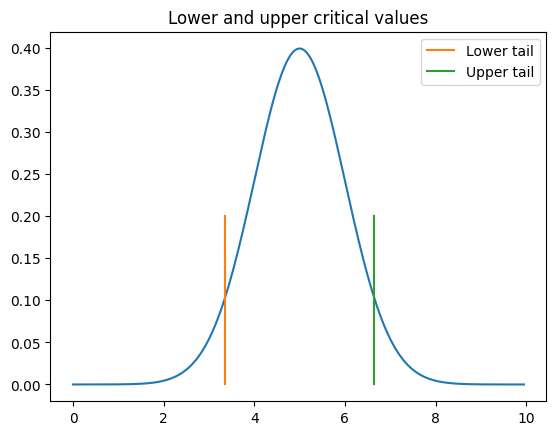

In [42]:
alpha = 0.05
lower = norm.ppf(alpha,5,1)
upper = norm.ppf(1-alpha,5,1)
plt.plot(x,y)
plt.plot([lower,lower],[0,0.2],label="Lower tail")
plt.plot([upper,upper],[0,0.2],label="Upper tail")
plt.legend()
plt.title("Lower and upper critical values")
plt.show()

The t-distribution works in a similar way, except the so-called "shape parameter" is the number of degrees of freedom, rather than the variance, and the location parameter (the mean) comes after the degrees of freedom. Comparing two means the degrees is size of dataset1 + size of dataset2 -2.

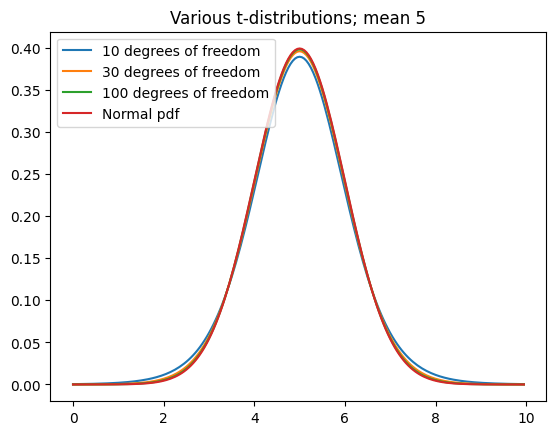

In [43]:
y10=t.pdf(x,10,5)
y30=t.pdf(x,30,5)
y100=t.pdf(x,100,5)
plt.plot(x,y10,label="10 degrees of freedom")
plt.plot(x,y30,label="30 degrees of freedom")
plt.plot(x,y100,label="100 degrees of freedom")
plt.plot(x,y,label='Normal pdf')
plt.legend(loc=2)
plt.title("Various t-distributions; mean 5")
plt.show()

## End of Appendix A